# Remote-jobs-analytics


In [106]:

import os
import json
import pandas as pd
import psycopg2
import requests
from dotenv import load_dotenv


In [107]:

try:
    import pandas
    import psycopg2
    import dotenv
    print("All required packages are installed.")
except ImportError as e:
    print(f"Missing package: {e.name}")


All required packages are installed.


In [108]:
load_dotenv() ## Load environment variables from a .env file

True

In [109]:
API_KEY = os.getenv("API_KEY")
API_HOST=os.getenv("API_HOST")
COUNTRY = 'us'
EMPLOYMENT_TYPE= 'fulltime'

In [110]:
url ="https://remote-jobs1.p.rapidapi.com/jobs"
headers =  {
	"x-rapidapi-key": API_KEY,
	"x-rapidapi-host": API_HOST
    
}
querystring = {"country":COUNTRY,
               "employmentType": EMPLOYMENT_TYPE}

In [111]:
print(querystring)

{'country': 'us', 'employmentType': 'fulltime'}


---------------- EXTRACTION ---------------

In [112]:
response = requests.get(url=url,
                        headers=headers,
                          params=querystring)


In [113]:
payload = response.json()


In [114]:
print(payload)

[{'id': 172882699, 'slug': 'business-analyst-curam', 'url': 'https://jobs.smartrecruiters.com/DerexTechnologiesInc/744000094252015-business-analyst-curam-', 'title': 'Business Analyst - Curam\xa0', 'description': '<p>Derex Technologies Inc specializes in providing IT consulting, staffing solutions and software services. Globally headquartered in Harrison New Jersey since 1996 Derex delivers the highest quality technology professionals and an array of customized IT talent solutions designed to improve productivity and drive results to global clients throughout North America.</p><p>With over two decades of unparalleled experience, Derex provides supports to its clientele, across such industries as Systems Integration, Banking and Finance, Telecommunications, Pharmaceutical and Life Sciences, Energy, Healthcare, Technology, Transportation, and local and federal Government agencies.</p><p>Title: Business Analyst - Curam&#xa0;</p><p>Term: 1 Year</p><p>Location:&#xa0; Washington, DC</p><p>In

In [115]:
# Debug cell — inspect response and payload structure safely
from pprint import pprint
import json

# show HTTP status (helps diagnose subscription/auth errors)
print("HTTP status:", getattr(response, "status_code", None))

# show type so you know why payload["response"] failed
print("payload type:", type(payload))

if isinstance(payload, list):
    print("payload is a list, length =", len(payload))
    if payload:
        print("first element type:", type(payload[0]))
        if isinstance(payload[0], dict):
            print("first element keys:")
            pprint(list(payload[0].keys()))
            if "response" in payload[0]:
                print("\npayload[0]['response'] preview:")
                pprint(payload[0]["response"])
        else:
            print("\nfirst element preview:")
            pprint(payload[0])
elif isinstance(payload, dict):
    print("payload is a dict; top-level keys:")
    pprint(list(payload.keys()))
    if "response" in payload:
        print("\npayload['response'] preview:")
        pprint(payload["response"])
else:
    print("payload preview:")
    pprint(payload)

# save raw payload for offline inspection
with open("payload.json", "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)
print("Saved payload.json")

HTTP status: 206
payload type: <class 'list'>
payload is a list, length = 100
first element type: <class 'dict'>
first element keys:
['id',
 'slug',
 'url',
 'title',
 'description',
 'datePosted',
 'dateDeleted',
 'skills',
 'categories',
 'employmentTypes',
 'locationTypes',
 'countries',
 'company']
Saved payload.json


In [116]:
# Extraction cell — normalize whatever structure we have into a list of records and a DataFrame
import pandas as pd

records = []

# If payload is a list, each item is likely a record
if isinstance(payload, list):
    for item in payload:
        if isinstance(item, dict):
            records.append(item)
        else:
            # wrap primitives so they still become rows
            records.append({"value": item})

# If payload is a dict, common patterns store results under 'data' or 'response'
elif isinstance(payload, dict):
    if "data" in payload and isinstance(payload["data"], list):
        records = payload["data"]
    elif "response" in payload and isinstance(payload["response"], list):
        records = payload["response"]
    else:
        # fallback: treat the whole dict as one record
        records = [payload]

else:
    # non-list/dict payload -> single record
    records = [{"payload": payload}]

print("Extracted records count:", len(records))

# Try to convert to DataFrame and save
try:
    df = pd.json_normalize(records)
    print("DataFrame shape:", df.shape)
    display(df.head())
    df.to_csv("remote_jobs.csv", index=False)
    print("Saved remote_jobs.csv")
except Exception as e:
    print("Could not convert to DataFrame:", e)
    from pprint import pprint
    pprint(records[:5])

Extracted records count: 100
DataFrame shape: (100, 24)


,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
0,172882699,business-analyst-curam,https://jobs.smartrecruiters.com/DerexTechnolo...,Business Analyst - Curam,<p>Derex Technologies Inc specializes in provi...,2025-11-18T18:24:44+00:00,None,None,[business],[fulltime],...,http://www.derextech.com,None,None,None,None,None,None,None,None,None
1,172882698,program-manager-master,https://jobs.smartrecruiters.com/DerexTechnolo...,Program Manager Master,<p>Derex Technologies Inc specializes in provi...,2025-11-18T18:27:46+00:00,None,None,None,[fulltime],...,http://www.derextech.com,None,None,None,None,None,None,None,None,None
2,172882663,proposal-manager-federal-172882663,https://jobs.smartrecruiters.com/ProcoreTechno...,"Proposal Manager, Federal",<p>We’re looking for a <strong>Proposal Manage...,2025-11-18T17:13:51+00:00,None,None,None,[fulltime],...,None,None,None,None,None,None,None,None,None,None
3,172882662,senior-counsel-global-channels-and-professiona...,https://jobs.smartrecruiters.com/ProcoreTechno...,"Senior Counsel, Global Channels and Profession...","<p>We’re looking for a<strong> Senior Counsel,...",2025-11-18T17:21:43+00:00,None,[jira],"[counsel, legal]",[fulltime],...,None,None,None,None,None,None,None,None,None,None
4,172882651,media-specialist-remote,https://jobs.smartrecruiters.com/Vericast/7440...,Media Specialist (Remote),<p>Vericast is the financial institution (FI) ...,2025-11-18T20:32:28+00:00,None,None,None,[fulltime],...,http://vericast.com,https://www.linkedin.com/company/vericastmarke...,1001-5000,Privately Held,,,Financial Services,"[15955 La Cantera Pkwy, San Antonio, Texas 782...",Vericast is the FI performance partner. We hel...,[Financial Solutions]


Saved remote_jobs.csv


In [117]:
remote_jobs=df.copy()

#copy for EDA/cleaning

In [118]:
remote_jobs_raw=df.copy()

In [119]:
remote_jobs_raw.to_csv('remote_jobs_raw.csv',index=False)

In [120]:
print(f"Backup saved -> remote_jobs_raw.csv")

Backup saved -> remote_jobs_raw.csv


In [121]:
df= pd.read_csv("remote_jobs.csv")
df

,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
0,172882699,business-analyst-curam,https://jobs.smartrecruiters.com/DerexTechnolo...,Business Analyst - Curam,<p>Derex Technologies Inc specializes in provi...,2025-11-18T18:24:44+00:00,NaN,NaN,['business'],['fulltime'],...,http://www.derextech.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172882698,program-manager-master,https://jobs.smartrecruiters.com/DerexTechnolo...,Program Manager Master,<p>Derex Technologies Inc specializes in provi...,2025-11-18T18:27:46+00:00,NaN,NaN,NaN,['fulltime'],...,http://www.derextech.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,172882663,proposal-manager-federal-172882663,https://jobs.smartrecruiters.com/ProcoreTechno...,"Proposal Manager, Federal",<p>We’re looking for a <strong>Proposal Manage...,2025-11-18T17:13:51+00:00,NaN,NaN,NaN,['fulltime'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,172882662,senior-counsel-global-channels-and-professiona...,https://jobs.smartrecruiters.com/ProcoreTechno...,"Senior Counsel, Global Channels and Profession...","<p>We’re looking for a<strong> Senior Counsel,...",2025-11-18T17:21:43+00:00,NaN,['jira'],"['counsel', 'legal']",['fulltime'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,172882651,media-specialist-remote,https://jobs.smartrecruiters.com/Vericast/7440...,Media Specialist (Remote),<p>Vericast is the financial institution (FI) ...,2025-11-18T20:32:28+00:00,NaN,NaN,NaN,['fulltime'],...,http://vericast.com,https://www.linkedin.com/company/vericastmarke...,1001-5000,Privately Held,NaN,NaN,Financial Services,"['15955 La Cantera Pkwy, San Antonio, Texas 78...",Vericast is the FI performance partner. We hel...,['Financial Solutions']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,172861601,principle-software-engineer-remote-us-172861601,https://apply.workable.com/j/3CD94BC078,Principle Software Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,"['c#', 'cicd', 'linux', 'python', 'rust']","['engineering', 'software-development']",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
96,172861600,principal-site-reliability-engineer-remote-us-...,https://apply.workable.com/j/0D8E725FBE,Principal Site Reliability Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,"['aws', 'cicd', 'java', 'javascript', 'nodejs']","['engineering', 'site-reliability-engineering'...",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
97,172861595,manager-digital-merchandising-remote-us,https://apply.workable.com/j/C8D8244CE7,"Manager, Digital Merchandising (Remote - US)",<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,['magento'],NaN,['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
98,172861591,it-manager-remote-us-172861591,https://apply.workable.com/j/43F4592B78,IT Manager (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,NaN,NaN,['fulltime'],...,https://www.jobgether.com,h

--------- EDA --------

Inspecting structure

In [122]:
print(f" The table has {df.shape[0]} row and {df.shape[1]} columns")


 The table has 100 row and 24 columns


In [123]:
df.head(10)

,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
0,172882699,business-analyst-curam,https://jobs.smartrecruiters.com/DerexTechnolo...,Business Analyst - Curam,<p>Derex Technologies Inc specializes in provi...,2025-11-18T18:24:44+00:00,NaN,NaN,['business'],['fulltime'],...,http://www.derextech.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172882698,program-manager-master,https://jobs.smartrecruiters.com/DerexTechnolo...,Program Manager Master,<p>Derex Technologies Inc specializes in provi...,2025-11-18T18:27:46+00:00,NaN,NaN,NaN,['fulltime'],...,http://www.derextech.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,172882663,proposal-manager-federal-172882663,https://jobs.smartrecruiters.com/ProcoreTechno...,"Proposal Manager, Federal",<p>We’re looking for a <strong>Proposal Manage...,2025-11-18T17:13:51+00:00,NaN,NaN,NaN,['fulltime'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,172882662,senior-counsel-global-channels-and-professiona...,https://jobs.smartrecruiters.com/ProcoreTechno...,"Senior Counsel, Global Channels and Profession...","<p>We’re looking for a<strong> Senior Counsel,...",2025-11-18T17:21:43+00:00,NaN,['jira'],"['counsel', 'legal']",['fulltime'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,172882651,media-specialist-remote,https://jobs.smartrecruiters.com/Vericast/7440...,Media Specialist (Remote),<p>Vericast is the financial institution (FI) ...,2025-11-18T20:32:28+00:00,NaN,NaN,NaN,['fulltime'],...,http://vericast.com,https://www.linkedin.com/company/vericastmarke...,1001-5000,Privately Held,NaN,NaN,Financial Services,"['15955 La Cantera Pkwy, San Antonio, Texas 78...",Vericast is the FI performance partner. We hel...,['Financial Solutions']
5,172882634,case-management-nurse-i-remote-eligible-172882634,https://jobs.smartrecruiters.com/WellmarkInc/7...,Case Management Nurse I (Remote Eligible),<p><strong>Why Wellmark</strong>: We are a mut...,2025-11-18T21:13:33+00:00,NaN,NaN,['management'],['fulltime'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,172882633,case-management-nurse-i-remote-eligible-172882633,https://jobs.smartrecruiters.com/WellmarkInc/7...,Case Management Nurse I (Remote Eligible),<p><strong>Why Wellmark</strong>: We are a mut...,2025-11-18T21:14:27+00:00,NaN,NaN,['management'],['fulltime'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,172882632,case-management-nurse-i-remote-eligible,https://jobs.smartrecruiters.com/WellmarkInc/7...,Case Management Nurse I (Remote Eligible),<p><strong>Why Wellmark</strong>: We are a mut...,2025-11-18T21:14:47+00:00,NaN,NaN,['management'],['fulltime'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,172882592,manager-provider-credentialing-ncqa,https://jobs.smartrecruiters.com/PriviaHealth/...,"Manager, Provider Credentialing (NCQA)","<p>Privia Health™ is a technology-driven, nati...",2025-11-18T17:45:42+00:00,NaN,NaN,NaN,['fulltime'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,172882549,vp-of-buildings-market-engagement,https://jobs.smartrecruiters.com/International...,VP of Buildings (Market Engagement),<p>Living Future is a non-profit organization ...,2025-11-18T17:31:40+00:00,NaN,['macos'],NaN,['fulltime'],...,http://www.living-future.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
df.tail(10)

,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
90,172861608,qaqc-engineer-icx-remote-us-172861608,https://apply.workable.com/j/D3D4F2A565,QAQC Engineer - ICX (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,NaN,['engineering'],['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
91,172861607,qa-automation-tech-lead-remote-us-172861607,https://apply.workable.com/j/9700288331,QA Automation Tech Lead (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,"['aws', 'azure', 'cicd', 'github', 'java', 'ja...","['qa', 'testing']",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
92,172861606,project-manager-ii-remote-us-172861606,https://apply.workable.com/j/95355A0DF7,Project Manager II (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,NaN,"['project-manager', 'management']",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
93,172861603,programmer-analyst-remote-us,https://apply.workable.com/j/6B6C470F2D,Programmer Analyst (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,"['.net', 'aspnet', 'c#', 'javascript', 'jquery']",NaN,['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
94,172861602,product-owner-remote-us-172861602,https://apply.workable.com/j/F4FAF7BBB0,Product Owner (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,NaN,['product'],['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
95,172861601,principle-software-engineer-remote-us-172861601,https://apply.workable.com/j/3CD94BC078,Principle Software Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,"['c#', 'cicd', 'linux', 'python', 'rust']","['engineering', 'software-development']",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...",NaN
96,172861600,principal-site-reliability-engineer-remote-us-...,https://apply.workable.com/j/0D8E725FBE,Principal Site Reliability Engineer (Remote - US),<p>This position is posted by Jobgether on beh...,2025-11-18T00:00:00+00:00,NaN,"['aws', 'cicd', 'java', 'javascript', 'nodejs']","['engineering', 'site-reliability-engineering'...",['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,2020.0,Find your dream remote jo

In [125]:
df.columns.tolist()

['id',
 'slug',
 'url',
 'title',
 'description',
 'datePosted',
 'dateDeleted',
 'skills',
 'categories',
 'employmentTypes',
 'locationTypes',
 'countries',
 'company.name',
 'company.slug',
 'company.website',
 'company.linkedinUrl',
 'company.linkedinSize',
 'company.linkedinType',
 'company.linkedinFounded',
 'company.linkedinTagline',
 'company.linkedinIndustry',
 'company.linkedinLocations',
 'company.linkedinDescription',
 'company.linkedinSpecialties']

In [126]:
df.dtypes

id                               int64
slug                            object
url                             object
title                           object
description                     object
datePosted                      object
dateDeleted                    float64
skills                          object
categories                      object
employmentTypes                 object
locationTypes                   object
countries                       object
company.name                    object
company.slug                    object
company.website                 object
company.linkedinUrl             object
company.linkedinSize            object
company.linkedinType            object
company.linkedinFounded        float64
company.linkedinTagline         object
company.linkedinIndustry        object
company.linkedinLocations       object
company.linkedinDescription     object
company.linkedinSpecialties     object
dtype: object

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           100 non-null    int64  
 1   slug                         100 non-null    object 
 2   url                          100 non-null    object 
 3   title                        100 non-null    object 
 4   description                  100 non-null    object 
 5   datePosted                   100 non-null    object 
 6   dateDeleted                  0 non-null      float64
 7   skills                       39 non-null     object 
 8   categories                   67 non-null     object 
 9   employmentTypes              100 non-null    object 
 10  locationTypes                100 non-null    object 
 11  countries                    100 non-null    object 
 12  company.name                 100 non-null    object 
 13  company.slug         

summary statistics

In [128]:
df.describe()

,id,dateDeleted,company.linkedinFounded
count,1.000000e+02,0.0,41.00000
mean,1.728772e+08,NaN,2014.95122
std,8.338399e+03,NaN,8.14847
min,1.728616e+08,NaN,1989.00000
25%,1.728801e+08,NaN,2012.00000
50%,1.728808e+08,NaN,2020.00000
75%,1.728824e+08,NaN,2020.00000
max,1.728827e+08,NaN,2020.00000


In [129]:
df.describe(include='all')

,id,slug,url,title,description,datePosted,dateDeleted,skills,categories,employmentTypes,...,company.website,company.linkedinUrl,company.linkedinSize,company.linkedinType,company.linkedinFounded,company.linkedinTagline,company.linkedinIndustry,company.linkedinLocations,company.linkedinDescription,company.linkedinSpecialties
count,1.000000e+02,100,100,100,100,100,0.0,39,67,100,...,67,49,49,49,41.00000,41,49,48,47,22
unique,NaN,100,100,95,96,79,NaN,36,30,2,...,34,23,6,2,NaN,18,13,22,21,17
top,NaN,business-analyst-curam,https://jobs.smartrecruiters.com/DerexTechnolo...,Case Management Nurse I (Remote Eligible),<p><strong>Why Wellmark</strong>: We are a mut...,2025-11-18T00:00:00+00:00,NaN,['jira'],['engineering'],['fulltime'],...,https://www.jobgether.com,https://www.linkedin.com/company/jobgether,11-50,Privately Held,NaN,Find your dream remote job,Internet Marketplace Platforms,"['Avenue Louise, Brussels, Brussels Region, BE']","Your future of work, like you've always dreamt...","['Cloud Computing', 'Enterprise Data Center', ..."
freq,NaN,1,1,3,3,22,NaN,2,9,86,...,22,22,26,48,NaN,22,22,22,22,4
mean,1.728772e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2014.95122,NaN,NaN,NaN,NaN,NaN
std,8.338399e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.14847,NaN,NaN,NaN,NaN,NaN
min,1.728616e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1989.00000,NaN,NaN,NaN,NaN,NaN
25%,1.728801e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2012.00000,NaN,NaN,NaN,NaN,NaN
50%,1.728808e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2020.00000,NaN,NaN,NaN,NaN,NaN
75%,1.728824e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2020.00000,NaN,NaN,NaN,NaN,NaN


In [130]:
cols_to_drop=[  "slug","url","dateDeleted",
    "company.slug","company.website","company.linkedinUrl",
    "company.linkedinSize","company.linkedinFounded",
    "company.linkedinTagline",
    "company.linkedinDescription","company.linkedinSpecialties","company.linkedinLocations"]

df.drop(columns=[c for c in cols_to_drop if c in df.columns],errors="ignore", inplace=True)
print("Dropped columns (if present).Remaining columns:",df.columns.tolist())

Dropped columns (if present).Remaining columns: ['id', 'title', 'description', 'datePosted', 'skills', 'categories', 'employmentTypes', 'locationTypes', 'countries', 'company.name', 'company.linkedinType', 'company.linkedinIndustry']


In [131]:
df.nunique()

id                          100
title                        95
description                  96
datePosted                   79
skills                       36
categories                   30
employmentTypes               2
locationTypes                 2
countries                    11
company.name                 48
company.linkedinType          2
company.linkedinIndustry     13
dtype: int64

missing values

In [132]:
df.duplicated().sum()

np.int64(0)

In [133]:
df.isna().sum().sort_values(ascending=False)

skills                      61
company.linkedinIndustry    51
company.linkedinType        51
categories                  33
datePosted                   0
description                  0
title                        0
id                           0
locationTypes                0
employmentTypes              0
company.name                 0
countries                    0
dtype: int64

In [134]:
cols_to_fill=['skills','datePosted','year','month','categories','company.linkedinType','company.linkedinLocations','company.linkedinIndustry']
for col in cols_to_fill:
    if col in df.columns:
        df[col].fillna('Unknown',inplace=True)
        print(f"Filled missing values in '{col}' with 'Unknown'")
    else:
        print(f"column '{col}' not found in dataframe")

Filled missing values in 'skills' with 'Unknown'
Filled missing values in 'datePosted' with 'Unknown'
column 'year' not found in dataframe
column 'month' not found in dataframe
Filled missing values in 'categories' with 'Unknown'
Filled missing values in 'company.linkedinType' with 'Unknown'
column 'company.linkedinLocations' not found in dataframe
Filled missing values in 'company.linkedinIndustry' with 'Unknown'


C:\Users\DELL\AppData\Local\Temp\ipykernel_10880\468856185.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown',inplace=True)


In [135]:
df.isna().sum()

id                          0
title                       0
description                 0
datePosted                  0
skills                      0
categories                  0
employmentTypes             0
locationTypes               0
countries                   0
company.name                0
company.linkedinType        0
company.linkedinIndustry    0
dtype: int64

In [136]:
df.head(7)

,id,title,description,datePosted,skills,categories,employmentTypes,locationTypes,countries,company.name,company.linkedinType,company.linkedinIndustry
0,172882699,Business Analyst - Curam,<p>Derex Technologies Inc specializes in provi...,2025-11-18T18:24:44+00:00,Unknown,['business'],['fulltime'],['remote'],['us'],Derex Technologies Inc,Unknown,Unknown
1,172882698,Program Manager Master,<p>Derex Technologies Inc specializes in provi...,2025-11-18T18:27:46+00:00,Unknown,Unknown,['fulltime'],['remote'],['us'],Derex Technologies Inc,Unknown,Unknown
2,172882663,"Proposal Manager, Federal",<p>We’re looking for a <strong>Proposal Manage...,2025-11-18T17:13:51+00:00,Unknown,Unknown,['fulltime'],['remote'],['us'],Procore Technologies,Unknown,Unknown
3,172882662,"Senior Counsel, Global Channels and Profession...","<p>We’re looking for a<strong> Senior Counsel,...",2025-11-18T17:21:43+00:00,['jira'],"['counsel', 'legal']",['fulltime'],['remote'],['us'],Procore Technologies,Unknown,Unknown
4,172882651,Media Specialist (Remote),<p>Vericast is the financial institution (FI) ...,2025-11-18T20:32:28+00:00,Unknown,Unknown,['fulltime'],['remote'],['us'],Vericast,Privately Held,Financial Services
5,172882634,Case Management Nurse I (Remote Eligible),<p><strong>Why Wellmark</strong>: We are a mut...,2025-11-18T21:13:33+00:00,Unknown,['management'],['fulltime'],['remote'],['us'],"Wellmark, Inc.",Unknown,Unknown
6,172882633,Case Management Nurse I (Remote Eligible),<p><strong>Why Wellmark</strong>: We are a mut...,2025-11-18T21:14:27+00:00,Unknown,['management'],['fulltime'],['remote'],['us'],"Wellmark, Inc.",Unknown,Unknown


In [137]:
new_col_names=['company.name','company.linkedinType','company.linkedinIndustry']

for col in new_col_names:
    if col in df.columns:
        
        df[col].fillna('Unknown', inplace=True)
        print(f"Filled missing values in '{col}' with 'Unknown'")
    else:
        print(f"Column '{col}' not found in DataFrame")


Filled missing values in 'company.name' with 'Unknown'
Filled missing values in 'company.linkedinType' with 'Unknown'
Filled missing values in 'company.linkedinIndustry' with 'Unknown'


C:\Users\DELL\AppData\Local\Temp\ipykernel_10880\4111529328.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)


In [138]:
df = df.rename(columns={
    'company.name': 'companyName',
    'company.linkedinType': 'companyType',
    'company.linkedinIndustry': 'Industry',

})


In [139]:
from bs4 import BeautifulSoup
df['description']= df['description'].apply(lambda x:BeautifulSoup(x,'html.parser').get_text() if isinstance(x,str) else x
)


In [140]:
import ast

cols = ['skills', 'categories', 'employmentTypes', 'locationTypes', 'countries']

df[cols] = df[cols].applymap(
    lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else x
)


C:\Users\DELL\AppData\Local\Temp\ipykernel_10880\2650470218.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[cols] = df[cols].applymap(


In [141]:
df.head(10)

,id,title,description,datePosted,skills,categories,employmentTypes,locationTypes,countries,companyName,companyType,Industry
0,172882699,Business Analyst - Curam,Derex Technologies Inc specializes in providin...,2025-11-18T18:24:44+00:00,Unknown,business,fulltime,remote,us,Derex Technologies Inc,Unknown,Unknown
1,172882698,Program Manager Master,Derex Technologies Inc specializes in providin...,2025-11-18T18:27:46+00:00,Unknown,Unknown,fulltime,remote,us,Derex Technologies Inc,Unknown,Unknown
2,172882663,"Proposal Manager, Federal",We’re looking for a Proposal Manager to join P...,2025-11-18T17:13:51+00:00,Unknown,Unknown,fulltime,remote,us,Procore Technologies,Unknown,Unknown
3,172882662,"Senior Counsel, Global Channels and Profession...","We’re looking for a Senior Counsel, Global Cha...",2025-11-18T17:21:43+00:00,jira,"counsel, legal",fulltime,remote,us,Procore Technologies,Unknown,Unknown
4,172882651,Media Specialist (Remote),Vericast is the financial institution (FI) per...,2025-11-18T20:32:28+00:00,Unknown,Unknown,fulltime,remote,us,Vericast,Privately Held,Financial Services
5,172882634,Case Management Nurse I (Remote Eligible),Why Wellmark: We are a mutual insurance compan...,2025-11-18T21:13:33+00:00,Unknown,management,fulltime,remote,us,"Wellmark, Inc.",Unknown,Unknown
6,172882633,Case Management Nurse I (Remote Eligible),Why Wellmark: We are a mutual insurance compan...,2025-11-18T21:14:27+00:00,Unknown,management,fulltime,remote,us,"Wellmark, Inc.",Unknown,Unknown
7,172882632,Case Management Nurse I (Remote Eligible),Why Wellmark: We are a mutual insurance compan...,2025-11-18T21:14:47+00:00,Unknown,management,fulltime,remote,us,"Wellmark, Inc.",Unknown,Unknown
8,172882592,"Manager, Provider Credentialing (NCQA)","Privia Health™ is a technology-driven, nationa...",2025-11-18T17:45:42+00:00,Unknown,Unknown,fulltime,remote,us,Privia Health,Unknown,Unknown
9,172882549,VP of Buildings (Market Engagement),Living Future is a non-profit organization who...,2025-11-18T17:31:40+00:00,macos,Unknown,fulltime,remote,us,International Living Future Institute,Unknown,Unknown


In [142]:
df.columns.tolist()

['id',
 'title',
 'description',
 'datePosted',
 'skills',
 'categories',
 'employmentTypes',
 'locationTypes',
 'countries',
 'companyName',
 'companyType',
 'Industry']

In [143]:
cols_to_string=['title','description','skills', 'categories', 'employmentTypes', 'locationTypes', 'countries','companyName','companyType','Industry']

df[cols_to_string] = df[cols_to_string].astype('string')


In [144]:

df['datePosted'] = pd.to_datetime(df['datePosted'], errors='coerce')


In [145]:
df.dtypes

id                               int64
title                   string[python]
description             string[python]
datePosted         datetime64[ns, UTC]
skills                  string[python]
categories              string[python]
employmentTypes         string[python]
locationTypes           string[python]
countries               string[python]
companyName             string[python]
companyType             string[python]
Industry                string[python]
dtype: object

In [146]:
df.head(5)

,id,title,description,datePosted,skills,categories,employmentTypes,locationTypes,countries,companyName,companyType,Industry
0,172882699,Business Analyst - Curam,Derex Technologies Inc specializes in providin...,2025-11-18 18:24:44+00:00,Unknown,business,fulltime,remote,us,Derex Technologies Inc,Unknown,Unknown
1,172882698,Program Manager Master,Derex Technologies Inc specializes in providin...,2025-11-18 18:27:46+00:00,Unknown,Unknown,fulltime,remote,us,Derex Technologies Inc,Unknown,Unknown
2,172882663,"Proposal Manager, Federal",We’re looking for a Proposal Manager to join P...,2025-11-18 17:13:51+00:00,Unknown,Unknown,fulltime,remote,us,Procore Technologies,Unknown,Unknown
3,172882662,"Senior Counsel, Global Channels and Profession...","We’re looking for a Senior Counsel, Global Cha...",2025-11-18 17:21:43+00:00,jira,"counsel, legal",fulltime,remote,us,Procore Technologies,Unknown,Unknown
4,172882651,Media Specialist (Remote),Vericast is the financial institution (FI) per...,2025-11-18 20:32:28+00:00,Unknown,Unknown,fulltime,remote,us,Vericast,Privately Held,Financial Services


In [147]:
df['employmentTypes'].value_counts()

employmentTypes
fulltime              86
fulltime, contract    14
Name: count, dtype: Int64

In [148]:
df['locationTypes'].value_counts()

locationTypes
remote            98
hybrid, remote     2
Name: count, dtype: Int64

In [149]:
df['countries'].value_counts()


countries
us                                    88
je, us                                 2
us, je                                 2
us, ca, gb                             1
ae, de, za, sg, us, gb                 1
de, ae, gb, bg, za, sg, ua, us         1
ae, sg, de, bg, ie, za, gb, ua, us     1
de, ae, sg, bg, ie, za, gb, ua, us     1
de, sg, bg, ae, ie, za, gb, ua, us     1
us, ge                                 1
gb, us, in, es, au                     1
Name: count, dtype: Int64

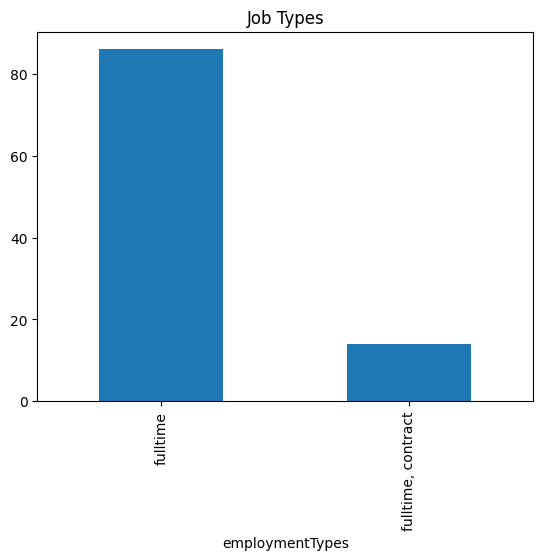

In [150]:
import matplotlib.pyplot as plt

df['employmentTypes'].value_counts().plot(kind='bar', title='Job Types')
plt.show()

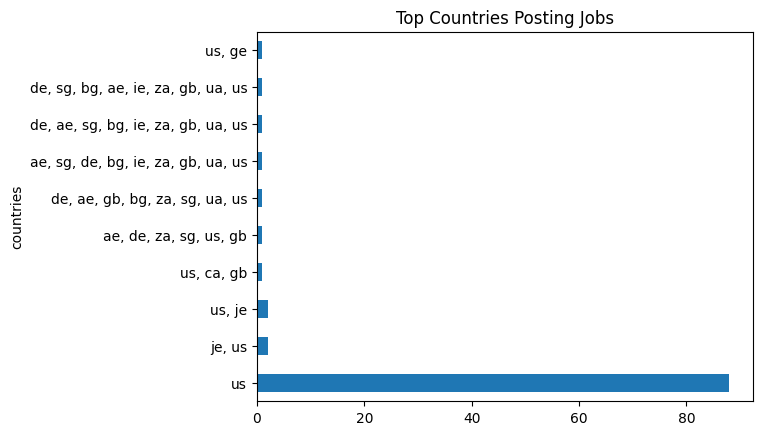

In [151]:
df['countries'].value_counts().head(10).plot(kind='barh', title='Top Countries Posting Jobs')
plt.show()

In [152]:
df.to_csv('remote_jobs_cleaned.csv', index=False)

In [154]:
from sqlalchemy import create_engine

dbname = os.getenv("POSTGRESQL_DB")
user = os.getenv("POSTGRESQL_USER")
password = os.getenv("POSTGRESQL_PASSWORD")
host = os.getenv("POSTGRESQL_HOST")
port = os.getenv("POSTGRESQL_PORT")



engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}")


df.to_sql("remote_jobs", engine, if_exists="replace", index=False)

print(" Data successfully loaded into PostgreSQL table 'remote_jobs'")

 Data successfully loaded into PostgreSQL table 'remote_jobs'
